### Import Libraries for development

In [1]:
import scipy
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline 

### Set random seed

##### Set random seed in order to get the same result after each time running the code 

In [2]:
tf.random.set_seed(456)

### Step 1: Read and Explore Data

In [3]:
dataframe = pd.read_csv("AAPL_3Y.csv",parse_dates = ['Date'],index_col = 'Date')
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-16,54.732498,55.747501,54.189999,55.537498,53.658726,116736000
2018-10-17,55.575001,55.660000,54.834999,55.297501,53.426846,91541600
2018-10-18,54.465000,54.935001,53.250000,54.005001,52.178062,130325200
2018-10-19,54.514999,55.314999,54.357498,54.827499,52.972744,132314800
2018-10-22,54.947498,55.840000,54.735001,55.162498,53.296410,115168400


Dimension of train data:  (543, 6)
Dimension of test data:  (234, 6)


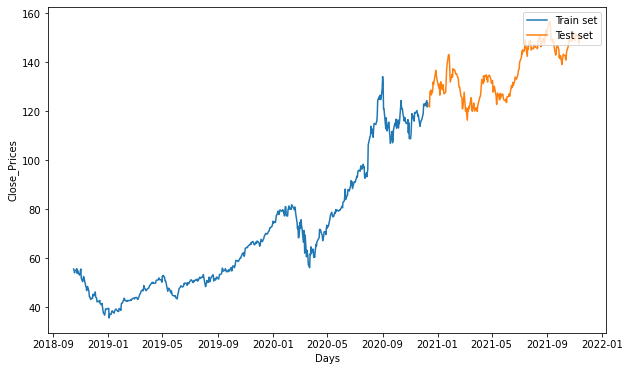

In [4]:
# Split train data and test data
training_size = int(len(dataframe)*0.7)
train_dataset, test_dataset = dataframe.iloc[:training_size], dataframe.iloc[training_size:]

# Plot train and test data
plt.figure(figsize = (10,6))
plt.plot(train_dataset.Close)
plt.plot(test_dataset.Close)
plt.xlabel('Days')
plt.ylabel('Close_Prices')
plt.legend(['Train set','Test set'], loc='upper right')

print('Dimension of train data: ', train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [5]:
#Split train data for X and Y
train_dataset = train_dataset.reset_index().drop('Date',axis = 1)

X_train = train_dataset.drop(['Close','Adj Close'], axis = 1)
Y_train = train_dataset[['Close']]

#Split test data for X and Y
test_dataset = test_dataset.reset_index().drop('Date',axis = 1)

X_test = test_dataset.drop(['Close','Adj Close'], axis = 1)
Y_test = test_dataset[['Close']]

In [6]:
#Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

#FIt the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(Y_train)

#Apply the scaler to training data
X_train_normalize = input_scaler.transform(X_train)
Y_train_normalize = output_scaler.transform(Y_train)

#Different scaler for input and output
scaler_x_test = MinMaxScaler(feature_range = (0,1))
scaler_y_test = MinMaxScaler(feature_range = (0,1))

#FIt the scaler using available training data
input_scaler_test = scaler_x_test.fit(X_test)
output_scaler_test = scaler_y_test.fit(Y_test)

#Apply the scaler to test data
X_test_normalize = input_scaler_test.transform(X_test)
Y_test_normalize = output_scaler_test.transform(Y_test)

print('X_train_normalize.shape:', X_train_normalize.shape)
print('Y_train_normalize.shape:', Y_train_normalize.shape)
print('X_test_normalize.shape:', X_test_normalize.shape)
print('Y_test_normalize.shape:', Y_test_normalize.shape)

print('X_train_normalize:\n', X_train_normalize)
print('Y_train_normalize:\n', Y_train_normalize)
print('X_test_normalize:\n', X_test_normalize)
print('Y_test_normalize:\n', Y_test_normalize)

X_train_normalize.shape: (543, 4)
Y_train_normalize.shape: (543, 1)
X_test_normalize.shape: (234, 4)
Y_test_normalize.shape: (234, 1)
X_train_normalize:
 [[0.18443328 0.19022651 0.19667473 0.18707717]
 [0.19272605 0.18936485 0.20346206 0.12096089]
 [0.1818003  0.18222552 0.18678312 0.22273856]
 ...
 [0.86987555 0.87198431 0.9217089  0.09651317]
 [0.87145039 0.88153619 0.89971589 0.18275556]
 [0.83178309 0.86105373 0.89077137 0.09411644]]
Y_train_normalize:
 [[0.20267152]
 [0.20023827]
 [0.18713407]
 [0.19547309]
 [0.19886953]
 [0.20414163]
 [0.18477682]
 [0.19671509]
 [0.18784378]
 [0.17755305]
 [0.18023979]
 [0.1943325 ]
 [0.20284897]
 [0.16548804]
 [0.15055888]
 [0.15608447]
 [0.17174866]
 [0.16804807]
 [0.15785872]
 [0.13175171]
 [0.12683445]
 [0.11307126]
 [0.12475605]
 [0.13012952]
 [0.11068867]
 [0.08818086]
 [0.08767394]
 [0.07629329]
 [0.08219906]
 [0.08123591]
 [0.09821814]
 [0.09469496]
 [0.09223633]
 [0.10805264]
 [0.08744583]
 [0.08245254]
 [0.0666616 ]
 [0.06947509]
 [0.06

In [7]:
# Create a 3D input 
def create_3D_dataset(X,Y, time_steps=1):
    X_dataset = []
    Y_dataset = []
    for i in range (len(X) - time_steps):
        V = X[i:i+time_steps,:]
        X_dataset.append(V)
        Y_dataset.append(Y[i+time_steps])
    return np.array(X_dataset), np.array(Y_dataset)

time_Steps = 30

X_test, Y_test = create_3D_dataset(X_test_normalize, Y_test_normalize, time_Steps)

X_train, Y_train = create_3D_dataset(X_train_normalize, Y_train_normalize, time_Steps)

print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape', X_test.shape)
print('Y_test.shape', Y_test.shape)

X_train.shape: (513, 30, 4)
Y_train.shape: (513, 1)
X_test.shape (204, 30, 4)
Y_test.shape (204, 1)


In [8]:
def create_LSTM_model(units):
    model = Sequential()
    model.add(LSTM(units = units, return_sequences=True,input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(loss = 'mse', optimizer = 'adam')
    return model

LSTM_model = create_LSTM_model(64)

In [9]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    #early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    record = model.fit(X_train, Y_train, epochs = 200, validation_split = 0.2, batch_size = 64,
                      shuffle = False)
    return record


print("\n\nLSTM_record")
LSTM_record = fit_model(LSTM_model)



LSTM_record
Epoch 1/200
7/7 [==============================] - 4s 151ms/step - loss: 0.0090 - val_loss: 0.0571
Epoch 2/200
7/7 [==============================] - 0s 51ms/step - loss: 0.0086 - val_loss: 0.0220
Epoch 3/200
7/7 [==============================] - 0s 50ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 4/200
7/7 [==============================] - 0s 27ms/step - loss: 0.0026 - val_loss: 0.0051
Epoch 5/200
7/7 [==============================] - 0s 28ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 6/200
7/7 [==============================] - 0s 29ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 7/200
7/7 [==============================] - 0s 29ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 8/200
7/7 [==============================] - 0s 28ms/step - loss: 0.0022 - val_loss: 0.0076
Epoch 9/200
7/7 [==============================] - 0s 29ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 10/200
7/7 [==============================] - 0s 28ms/step - loss: 0.0015 - val_loss: 0.0068
Epoc

7/7 [==============================] - 0s 29ms/step - loss: 7.8062e-04 - val_loss: 0.0026
Epoch 163/200
7/7 [==============================] - 0s 27ms/step - loss: 6.7620e-04 - val_loss: 0.0025
Epoch 164/200
7/7 [==============================] - 0s 29ms/step - loss: 8.1296e-04 - val_loss: 0.0026
Epoch 165/200
7/7 [==============================] - 0s 28ms/step - loss: 8.2268e-04 - val_loss: 0.0026
Epoch 166/200
7/7 [==============================] - 0s 28ms/step - loss: 7.6940e-04 - val_loss: 0.0025
Epoch 167/200
7/7 [==============================] - 0s 28ms/step - loss: 8.3200e-04 - val_loss: 0.0027
Epoch 168/200
7/7 [==============================] - 0s 28ms/step - loss: 8.1424e-04 - val_loss: 0.0029
Epoch 169/200
7/7 [==============================] - 0s 28ms/step - loss: 7.5280e-04 - val_loss: 0.0025
Epoch 170/200
7/7 [==============================] - 0s 28ms/step - loss: 9.7716e-04 - val_loss: 0.0031
Epoch 171/200
7/7 [==============================] - 0s 28ms/step - loss: 8.70

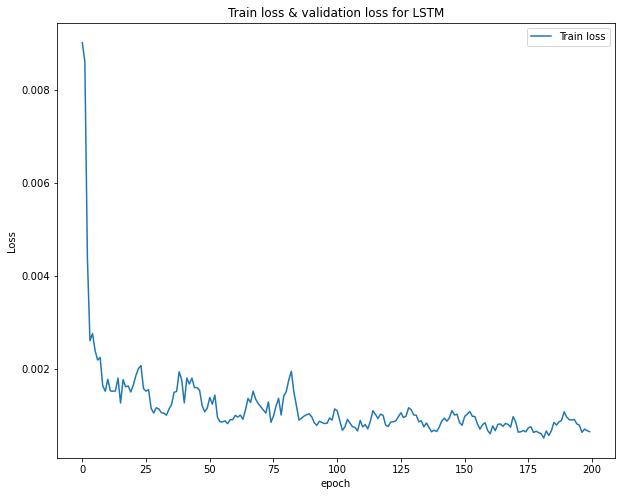

In [10]:
# Flot train loss and validation loss
def plot_loss (record,model_name):
    plt.figure(figsize = (10,8))
    plt.plot(record.history['loss'])
    #plt.plot(record.history['val_loss'])
    plt.title('Train loss & validation loss for '+ model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss','Validation Loss'], loc='upper right')
    
#plot_loss(BidirecLSTM_record,'Bidirectional_LSTM')
plot_loss(LSTM_record,'LSTM')

In [11]:
Y_test_read = scaler_y_test.inverse_transform(Y_test) 
Y_train_read = scaler_y.inverse_transform(Y_train)
X_test

array([[[0.0895916 , 0.06402606, 0.11367218, 0.30314996],
        [0.09407113, 0.08003246, 0.13960194, 0.25197388],
        [0.13992088, 0.20347264, 0.2074384 , 0.76707503],
        ...,
        [0.45454549, 0.52767248, 0.49266645, 0.48474774],
        [0.63346535, 0.66983176, 0.53247758, 0.7695034 ],
        [0.64743107, 0.6483995 , 0.65898366, 0.3787121 ]],

       [[0.09407113, 0.08003246, 0.13960194, 0.25197388],
        [0.13992088, 0.20347264, 0.2074384 , 0.76707503],
        [0.22081701, 0.2162234 , 0.27108431, 0.37751111],
        ...,
        [0.63346535, 0.66983176, 0.53247758, 0.7695034 ],
        [0.64743107, 0.6483995 , 0.65898366, 0.3787121 ],
        [0.64295114, 0.6483995 , 0.63383984, 0.65885451]],

       [[0.13992088, 0.20347264, 0.2074384 , 0.76707503],
        [0.22081701, 0.2162234 , 0.27108431, 0.37751111],
        [0.26007894, 0.24905051, 0.30984793, 0.35211345],
        ...,
        [0.64743107, 0.6483995 , 0.65898366, 0.3787121 ],
        [0.64295114, 0.648399

In [12]:
# Make Prediction
def predict(model):
    prediction = model.predict(X_test)
    prediction = scaler_y_test.inverse_transform(prediction)
    return prediction

#prediction_of_BidirectionLSTM = predict(BidirecLSTM_model)
prediction_of_LSTM = predict(LSTM_model)


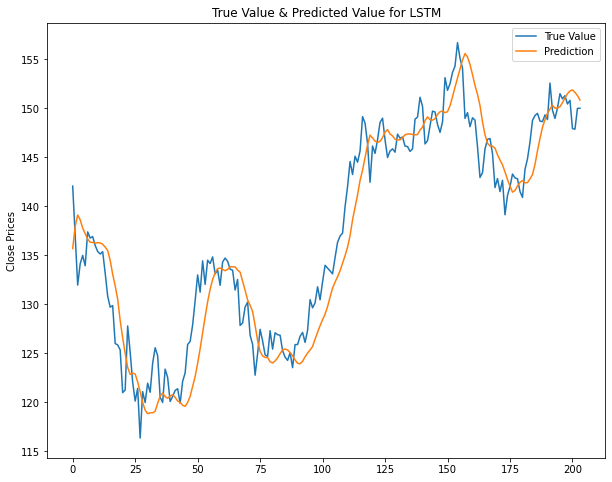

In [13]:
# Plot true future vs prediction
def plot_result(prediction, y_test, model_name):
    plt.figure(figsize = (10,8))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='True Value')
    plt.plot(np.arange(range_future), np.array(prediction), label='Prediction')
    plt.legend(loc='upper right')
    plt.title('True Value & Predicted Value for '+ model_name)
    plt.ylabel('Close Prices')
    
#plot_result(prediction_of_BidirectionLSTM, Y_test_read, 'BidirectionLSTM')
plot_result(prediction_of_LSTM, Y_test_read, 'LSTM')

In [14]:
print(prediction_of_LSTM.shape)
print(Y_test_read.shape)

(204, 1)
(204, 1)


In [15]:
def result_evaluation(predictions, actual, model_name):
    residuals = predictions - actual
    mse = np.square(residuals).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(residuals).mean()
    
    print(model_name + " RMSE and MAE results:")
    print('Root Mean Square Error(RMSE): {:.4f}'.format(rmse))
    print('Mean Absolute Error(MAE): {:.4f}'.format(mae))
    print('\n')
    
#result_evaluation(prediction_of_BidirectionLSTM,Y_test_read, 'BidirectionLSTM')
result_evaluation(prediction_of_LSTM,Y_test_read, 'LSTM')

LSTM RMSE and MAE results:
Root Mean Square Error(RMSE): 3.2027
Mean Absolute Error(MAE): 2.5461




split 70%

LSTM RMSE and MAE results: <br>
Root Mean Square Error(RMSE): 2.9620 <br>
Mean Absolute Error(MAE): 2.3489 <br>

split 80%

LSTM RMSE and MAE results: <br>
Root Mean Square Error(RMSE): 2.2344 <br>
Mean Absolute Error(MAE): 1.7807 <br>


LSTM RMSE and MAE results for 5 year: <br>
Root Mean Square Error(RMSE): 3.0527<br>
Mean Absolute Error(MAE): 2.4068 <br>